## Guide on fine-tuning a Phi-3-mini model for Python code generation utilizing QLoRA via Hugging Face Hub

## Installing and loading the libraries

In [1]:
!pip install -qqq --upgrade bitsandbytes transformers peft accelerate datasets trl flash_attn

In [2]:
!pip show torch

Name: torch
Version: 2.2.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, bitsandbytes, flash-attn, peft, torchaudio, torchvision, trl


In [2]:
# 'pip' is a package installer for Python. It is used to install and manage software packages/libraries written in Python.

# '!pip install huggingface_hub' is a command that installs the 'huggingface_hub' package.
# 'huggingface_hub' is a package that provides a simple API for downloading and uploading files to the Hugging Face Hub.

# '!pip install python-dotenv' is a command that installs the 'python-dotenv' package.
# 'python-dotenv' is a package that allows you to specify environment variables in a .env file, which can be read and used in your Python project.
!pip install huggingface_hub
!pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# 'pip' is a package installer for Python. It is used to install and manage software packages/libraries written in Python.

# '!pip install wandb -qqq' is a command that installs the 'wandb' package.

# 'wandb' (Weights & Biases) is a tool for machine learning experiment tracking, dataset versioning, and model sharing.

# '-qqq' is an option that makes the output of the command less verbose.
!pip install wandb -qqq

In [4]:
# 'pip' is a package installer for Python. It is used to install and manage software packages/libraries written in Python.

# '!pip install absl-py nltk rouge_score' is a command that installs three Python packages: 'absl-py', 'nltk', and 'rouge_score'.

# 'absl-py' (Abseil Python Common Libraries) is a collection of Python library code that is used within Google to allow Python applications to implement command-line flags and other common utilities.

# 'nltk' (Natural Language Toolkit) is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources.

# 'rouge_score' is a Python package for calculating the ROUGE (Recall-Oriented Understudy for Gisting Evaluation) score, which is a set of metrics used to evaluate automatic summarization and machine translation.
!pip install absl-py nltk rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 20.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=24d2cc97141c4bd8d21b3fb26ebfafa3b002a93c274a3dfcc0b8771b40c003a2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
# 'pip' is a package installer for Python. It is used to install and manage software packages/libraries written in Python.

# '!pip list' is a command that lists all installed Python packages.

# '|' is a pipe. It takes the output of the command on its left and uses it as the input to the command on its right.

# 'grep' is a command-line utility for searching plain-text data sets for lines that match a regular expression. In this case, it's used to filter the output of 'pip list'.

# 'transformers.' is the regular expression that 'grep' is searching for. It will match any line that contains 'transformers.'.

# So, '!pip list | grep transformers.' is a command that lists all installed Python packages and filters the list for packages that contain 'transformers.' in their name.
!pip list | grep transformers.

transformers                      4.45.1

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


## Importing the libraries

In [6]:
# This code block imports several modules and functions that are needed for the script.

# 'randrange' is a function from the 'random' module that generates a random number within the specified range.

# 'torch' is a library for scientific computing that provides a wide range of functionalities for dealing with tensors.

# 'load_dataset' is a function from the 'datasets' library that loads a dataset from the Hugging Face datasets hub.

# 'LoraConfig', 'prepare_model_for_kbit_training', and 'PeftModel' are classes and functions from the 'peft' library that are used for configuring and preparing the model for training.

# 'AutoModelForCausalLM', 'AutoTokenizer', 'BitsAndBytesConfig', 'TrainingArguments', 'set_seed', and 'pipeline' are classes and functions from the 'transformers' library that are used for creating and training the model.

# 'SFTTrainer' is a class from the 'trl' library that is used for training the model.



from random import randrange

import torch
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, TaskType, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    set_seed,
    pipeline
)
from trl import SFTTrainer

## Setting Global Parameters

In [7]:
# 'model_id' and 'model_name' are the identifiers for the pre-trained model from Hugging Face hub that you want to fine-tune.
model_id =  "microsoft/Phi-3-mini-4k-instruct"
model_name =  "microsoft/Phi-3-mini-4k-instruct"

# 'dataset_name' is the identifier for the dataset that you want to use for fine-tuning.
dataset_name = "bigcode/self-oss-instruct-sc2-exec-filter-50k"

# 'dataset_split' is the split of the dataset that you want to use for fine-tuning. In this case, it is set to 'train', which means that the training split of the dataset will be used.
dataset_split= "train"

# 'new_model' is the name that you want to give to the fine-tuned model.
new_model = "new-model-name"

# 'hf_model_repo' is the identifier for the Hugging Face repository where you want to save the fine-tuned model.
hf_model_repo="username/"+new_model

# Load Model on GPU

# 'device_map' is a dictionary that maps devices to model parts. In this case, it is set to {"": 0}, which means that the entire model will be loaded on GPU 0.
device_map = {"": 0}

# Bits and Bytes configuration for the model

# 'use_4bit' is a boolean that controls whether 4-bit precision should be used for loading the base model.
use_4bit = True

# 'bnb_4bit_compute_dtype' is the data type that should be used for computations with the 4-bit base model. In this case, it is set to 'bfloat16'.
bnb_4bit_compute_dtype = "bfloat16"

# 'bnb_4bit_quant_type' is the type of quantization that should be used for the 4-bit base model. In this case, it is set to 'nf4'.
bnb_4bit_quant_type = "nf4"

# 'use_double_quant' is a boolean that controls whether nested quantization should be used for the 4-bit base model.
use_double_quant = True

# LoRA configuration for the model

# 'lora_r' is the dimension of the LoRA attention.
lora_r = 16

# 'lora_alpha' is the alpha parameter for LoRA scaling.
lora_alpha = 16

# 'lora_dropout' is the dropout probability for LoRA layers.
lora_dropout = 0.05

# 'target_modules' is a list of the modules that should be targeted by LoRA.
target_modules= ['k_proj', 'q_proj', 'v_proj', 'o_proj', "gate_proj", "down_proj", "up_proj"]

# 'set_seed(1234)' sets the random seed for reproducibility.
set_seed(34)


## Connect to Huggingface Hub

IMPORTANT: The upcoming section's execution will vary based on your code execution environment and the configuration of your API Keys.

Interactive login to Hugging Face Hub is possible.

In [8]:
# 'huggingface_hub' is a library that provides tools for working with the Hugging Face Model Hub.

# 'notebook_login' is a function from the 'huggingface_hub' library that logs you into the Hugging Face Model Hub from a Jupyter notebook.

# 'from huggingface_hub import notebook_login' imports the 'notebook_login' function from the 'huggingface_hub' library. This allows you to use 'notebook_login' directly instead of having to write 'huggingface_hub.notebook_login'.

# 'notebook_login()' calls the 'notebook_login' function, which opens a new browser window where you can log into the Hugging Face Model Hub. After you have logged in, the function will store your Hugging Face Model Hub credentials in a file on your local machine, so you don't have to log in again in the future.
from huggingface_hub import notebook_login
notebook_login()

Alternatively, you can supply a .env file that contains the Hugging Face token.

In [10]:
# 'huggingface_hub' is a library that provides tools for working with the Hugging Face Model Hub.

# 'login' is a function from the 'huggingface_hub' library that logs you into the Hugging Face Model Hub.

# 'dotenv' is a library that allows you to load environment variables from a .env file.

# 'load_dotenv' is a function from the 'dotenv' library that loads environment variables from a .env file.

# 'os' is a standard Python library that provides functions for interacting with the operating system.

# 'os.getenv' is a function from the 'os' library that gets the value of an environment variable.

# 'from huggingface_hub import login' imports the 'login' function from the 'huggingface_hub' library.

# 'from dotenv import load_dotenv' imports the 'load_dotenv' function from the 'dotenv' library.

# 'import os' imports the 'os' library.

# 'load_dotenv()' calls the 'load_dotenv' function, which loads environment variables from a .env file.

# 'login(token=os.getenv("HF_HUB_TOKEN"))' calls the 'login' function with the value of the 'HF_HUB_TOKEN' environment variable as the 'token' parameter. This logs you into the Hugging Face Model Hub using the token stored in the 'HF_HUB_TOKEN' environment variable.
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv()
login(token=os.getenv("HF_HUB_TOKEN"))

## Load the dataset with the instruction set

In [9]:
# 'load_dataset' is a function from the 'datasets' library that loads a dataset from the Hugging Face Dataset Hub.

# 'dataset_name' is the identifier for the dataset that you want to load.

# 'split' is the split of the dataset that you want to load. In this case, it is set to the value of 'dataset_split'.

# 'dataset = load_dataset(dataset_name, split=dataset_split)' loads the specified split of the specified dataset from the Hugging Face Dataset Hub and assigns it to the variable 'dataset'.

# 'len(dataset)' returns the size of the dataset.

# 'print(f"dataset size: {len(dataset)}")' prints the size of the dataset.

# 'randrange' is a function from the 'random' library that returns a random integer from the specified range.

# 'len(dataset)' is the range from which 'randrange' should choose a random integer. In this case, it is set to the size of the dataset, which means that 'randrange' will choose a random index from the dataset.

# 'dataset[randrange(len(dataset))]' returns a random example from the dataset.

# 'print(dataset[randrange(len(dataset))])' prints a random example from the dataset.
dataset = load_dataset(dataset_name, split=dataset_split)

dataset = dataset.train_test_split(test_size=0.99,seed=34)['train'] # adjust seed to attain different subsets of training data 
print(f"dataset size: {len(dataset)}")
print(dataset[randrange(len(dataset))])


README.md:   0%|          | 0.00/922 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50661 [00:00<?, ? examples/s]

dataset size: 506
{'fingerprint': None, 'sha1': 'e67e593a11ba7b50766cb82ff7882a7a8c5d04f8', 'seed': 'def is_struct_dtype_with_duplicated_field_labels(dtype):\n    """Check if struct item has duplicated field labels.\n\n    """\n\n    labels = {field.name for field in dtype}\n    return len(labels) < dtype.num_fields', 'response': 'To find the objects that have an attribute, we can use a list comprehension. The list comprehension iterates through the objects, checking if the attribute exists using the getattr() function. If it does, it adds the object to the new list.\n\n```python\ndef filter_objects_with_attribute(objects, attr):\n    return {obj for obj in objects if getattr(obj, attr, None) is not None}\n```', 'concepts': ['object attribute extraction', 'set data structure', 'sequence filtering'], 'prompt': 'Provide the best response to a given instruction. Follow the following steps to craft your response:\n1. reason about the given instruction\n2. provide a high-quality solution\n3

In [10]:
# 'dataset' is a variable that contains the dataset loaded from the Hugging Face Dataset Hub.

# 'dataset' when used alone like this in a Jupyter notebook cell, it will display the structure of the dataset. This includes information such as the number of examples in the dataset, the names and types of the fields in the dataset, and the shapes of the fields.

# This line of code is used to check the structure of the dataset to ensure that it is in the expected format before proceeding with further data processing or model training.
dataset

Dataset({
    features: ['fingerprint', 'sha1', 'seed', 'response', 'concepts', 'prompt', 'instruction', 'id'],
    num_rows: 506
})

In [11]:
# 'randrange' is a function from the 'random' library that returns a random integer from the specified range.

# 'len(dataset)' is the range from which 'randrange' should choose a random integer. In this case, it is set to the size of the dataset, which means that 'randrange' will choose a random index from the dataset.

# 'dataset[randrange(len(dataset))]' returns a random example from the dataset.

# 'print(dataset[randrange(len(dataset))])' prints a random example from the dataset. This is useful for getting a sense of what the data in the dataset looks like.
print(dataset[randrange(len(dataset))])

{'fingerprint': None, 'sha1': 'e05ddbecb7b2cba1a21b49df04251206b53db2f2', 'seed': 'def mat_idx_to_triu_fast(row, col, n):\n\t"""mat_idx_to_triu_fast(row, col, n)\n\n\tConvert two-dimensional index to linear index of upper triangle.\n\n\tThis is the fast implementation, which does not check the order of row and\n\tcol.\n\n\t:param int row: Matrix row index.\n\t:param int col: Matrix column index. Must be greater than row.\n\t:param int n: Matrix size.\n\t:returns: Linear index of position in upper triangle.\n\t:rtype: int\n\t"""\n\t# Messy but fast implementation\n\treturn (2 * n - row - 3) * row // 2 + col - 1', 'response': 'To write a Python function that converts calories to calories burned per day, you should follow these steps:\n\n1. Define a function named `calories_per_day` that takes in one argument, `calories`, representing the number of calories to be converted.\n2. Add a docstring to the function to provide documentation for its input and output.\n3. Divide the input `calorie

## Load the tokenizer to prepare the dataset

In [12]:
# 'tokenizer_id' is the identifier for the tokenizer that you want to load. In this case, it is set to the value of 'model_id', which means that the tokenizer associated with the pre-trained model will be loaded.

# 'AutoTokenizer' is a class from the 'transformers' library that provides a generic tokenizer class from which all other tokenizer classes inherit.

# 'from_pretrained' is a method of the 'AutoTokenizer' class that loads a tokenizer from the Hugging Face Model Hub.

# 'tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)' loads the tokenizer associated with 'tokenizer_id' from the Hugging Face Model Hub and assigns it to the variable 'tokenizer'.

# 'tokenizer.padding_side' is a property of the 'tokenizer' object that determines on which side of the input sequences padding should be added. It can be set to either 'left' or 'right'.

# 'tokenizer.padding_side = 'right'' sets 'tokenizer.padding_side' to 'right', which means that padding will be added to the right side of the input sequences. This is done to prevent warnings that can occur when 'tokenizer.padding_side' is set to 'left'.
tokenizer_id = model_id
tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)
tokenizer.padding_side = 'right' # to prevent warnings

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Function to generate the suitable format for our model.

In [13]:
# 'create_message_column' is a function that takes a row from a dataset and returns a dictionary with a single key-value pair. The key is 'messages' and the value is a list of dictionaries, each representing a message.

# 'row' is the input to the 'create_message_column' function. It is expected to be a dictionary with keys 'instruction', 'input', and 'output'.

# 'messages' is a list that will contain the messages.

# 'user' is a dictionary that represents a user message. The 'content' key contains the instruction and input from the row, and the 'role' key is set to 'user'.

# 'messages.append(user)' adds the user message to the 'messages' list.

# 'assistant' is a dictionary that represents an assistant message. The 'content' key contains the output from the row, and the 'role' key is set to 'assistant'.

# 'messages.append(assistant)' adds the assistant message to the 'messages' list.

# 'return {"messages": messages}' returns a dictionary with a single key-value pair. The key is 'messages' and the value is the 'messages' list.

# 'format_dataset_chatml' is a function that takes a row from a dataset and returns a dictionary with a single key-value pair. The key is 'text' and the value is the result of applying the chat template to the messages in the row.

# 'row' is the input to the 'format_dataset_chatml' function. It is expected to be a dictionary with a key 'messages'.

# 'return {"text": tokenizer.apply_chat_template(row["messages"], add_generation_prompt=False, tokenize=False)}' returns a dictionary with a single key-value pair. The key is 'text' and the value is the result of applying the chat template to the messages in the row. The 'add_generation_prompt' parameter is set to False, which means that no generation prompt will be added to the end of the text. The 'tokenize' parameter is set to False, which means that the text will not be tokenized.
def create_message_column(row):
    messages = []
    user = {
        "content": f"{row['instruction']}\n Input: {row['prompt']}",
        "role": "user"
    }
    messages.append(user)
    assistant = {
        "content": f"{row['response']}",
        "role": "assistant"
    }
    messages.append(assistant)
    return {"messages": messages}

def format_dataset_chatml(row):
    return {"text": tokenizer.apply_chat_template(row["messages"], add_generation_prompt=False, tokenize=False)}

Implement the ChatML format on our dataset.

In [14]:
# 'dataset' is a variable that contains the dataset loaded from the Hugging Face Dataset Hub.

# 'map' is a method of the 'Dataset' class that applies a function to each example in the dataset.

# 'create_message_column' is a function that takes a row from a dataset and returns a dictionary with a single key-value pair. The key is 'messages' and the value is a list of dictionaries, each representing a message.

# 'dataset_chatml = dataset.map(create_message_column)' applies the 'create_message_column' function to each example in 'dataset' and assigns the result to 'dataset_chatml'. This transforms the dataset into a format where each example is a list of messages.

# 'format_dataset_chatml' is a function that takes a row from a dataset and returns a dictionary with a single key-value pair. The key is 'text' and the value is the result of applying the chat template to the messages in the row.

# 'dataset_chatml = dataset_chatml.map(format_dataset_chatml)' applies the 'format_dataset_chatml' function to each example in 'dataset_chatml'. This transforms the dataset into a format where each example is a single string of text that represents a conversation.
dataset_chatml = dataset.map(create_message_column)
dataset_chatml = dataset_chatml.map(format_dataset_chatml)

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

In [15]:
# 'dataset_chatml' is a variable that contains the dataset that has been transformed into a format where each example is a single string of text that represents a conversation.

# 'dataset_chatml[0]' returns the first example in 'dataset_chatml'.

# This line of code is used to check the first example in the transformed dataset to ensure that the transformation was performed correctly.
dataset_chatml[0]

{'fingerprint': None,
 'sha1': '6f0ec664fa134a77846988552096521ed5b7de7d',
 'seed': 'def is_subpath(path2Test, path_, allowEquals=False):\n    """\n    Check if path2Test is a sub-path of path.\n    Only for clean, absolute (unix) paths without trailing /. No filesystem-access involved!\n    """\n    assert path2Test[-1] != \'/\' and path_[-1] != \'/\'\n    if allowEquals and path2Test == path_:\n        return True\n    return path2Test.startswith(path_ + \'/\')',
 'response': 'To check if a given path is a subpath of another path, you can use the following steps:\n\n1. Check if either of the given paths is empty or `None`, and return the appropriate value.\n2. Split both paths into parts, using the `/` character as the delimiter.\n3. Iterate over the parts in the `other` path until you find the first part that is not in the `path` parts.\n4. If the first part that is not in the `path` parts is the same as the last part in the `path` parts, it means that the `path` is a subpath of the

In [23]:
# 'dataset_chatml' is a variable that contains the dataset that has been transformed into a format where each example is a single string of text that represents a conversation.

# 'train_test_split' is a method of the 'Dataset' class that splits the dataset into a training set and a test set.

# 'test_size=0.05' is a parameter of the 'train_test_split' method that specifies the proportion of the dataset to include in the test set. In this case, it is set to 0.05, which means that 5% of the dataset will be included in the test set.

# 'seed=1234' is a parameter of the 'train_test_split' method that specifies the seed for the random number generator. This is used to ensure that the split is reproducible.

# 'dataset_chatml = dataset_chatml.train_test_split(test_size=0.05, seed=1234)' splits 'dataset_chatml' into a training set and a test set and assigns the result to 'dataset_chatml'. The result is a dictionary with two key-value pairs. The keys are 'train' and 'test', and the values are the training set and the test set, respectively.

# 'dataset_chatml' when used alone like this in a Jupyter notebook cell, it will display the structure of the training set and the test set. This includes information such as the number of examples in each set, the names and types of the fields in the sets, and the shapes of the fields.

# This line of code is used to check the structure of the training set and the test set to ensure that the split was performed correctly.
dataset_chatml = dataset_chatml.train_test_split(test_size=0.05, seed=12)
dataset_chatml

DatasetDict({
    train: Dataset({
        features: ['fingerprint', 'sha1', 'seed', 'response', 'concepts', 'prompt', 'instruction', 'id', 'messages', 'text'],
        num_rows: 480
    })
    test: Dataset({
        features: ['fingerprint', 'sha1', 'seed', 'response', 'concepts', 'prompt', 'instruction', 'id', 'messages', 'text'],
        num_rows: 26
    })
})

## Instruction fine-tune a Phi-3-mini model using QLORA and trl

Initially, we attempt to recognize our GPU.

In [16]:
# 'torch' is a library for scientific computing that provides a wide range of functionalities for dealing with tensors, which are multi-dimensional arrays.

# 'torch.cuda.is_bf16_supported()' is a function that checks if BF16 is supported on the current GPU. BF16 is a data type that uses 16 bits, like float16, but allocates more bits to the exponent, which can result in higher precision.

# 'compute_dtype' is a variable that will hold the data type to be used for computations.

# 'attn_implementation' is a variable that will hold the type of attention implementation to be used.

# 'if torch.cuda.is_bf16_supported():' checks if BF16 is supported on the current GPU. If it is, the following block of code is executed.

# 'compute_dtype = torch.bfloat16' sets 'compute_dtype' to 'torch.bfloat16', which is the BF16 data type in PyTorch.

# 'attn_implementation = 'flash_attention_2'' sets 'attn_implementation' to 'flash_attention_2', which is a type of attention implementation.

# 'else:' specifies that the following block of code should be executed if BF16 is not supported on the current GPU.

# 'compute_dtype = torch.float16' sets 'compute_dtype' to 'torch.float16', which is the float16 data type in PyTorch.

# 'attn_implementation = 'sdpa'' sets 'attn_implementation' to 'sdpa', which is a type of attention implementation.

# 'print(attn_implementation)' prints the value of 'attn_implementation', which is the type of attention implementation to be used.

# 'print(compute_dtype)' prints the value of 'compute_dtype', which is the data type to be used for computations.
if torch.cuda.is_bf16_supported():
  compute_dtype = torch.bfloat16
  attn_implementation = 'flash_attention_2'
else:
  compute_dtype = torch.float16
  #attn_implementation = 'sdpa'
  attn_implementation = 'eager'


print(attn_implementation)
print(compute_dtype)

eager
torch.float16


## Load the tokenizer and model to finetune

In [40]:
# 'AutoTokenizer' is a class from the Hugging Face Transformers library that provides a tokenizer for a given pre-trained model.

# 'from_pretrained' is a method of the 'AutoTokenizer' class that loads a tokenizer from a pre-trained model.

# 'model_name' is a variable that contains the name of the pre-trained model.

# 'trust_remote_code=True' is a parameter that allows the execution of remote code when loading the tokenizer.

# 'add_eos_token=True' is a parameter that adds an end-of-sentence token to the tokenizer.

# 'use_fast=True' is a parameter that uses the fast version of the tokenizer, if available.

# 'tokenizer.pad_token = tokenizer.unk_token' sets the padding token of the tokenizer to be the same as the unknown token.

# 'tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)' sets the ID of the padding token to be the same as the ID of the padding token.

# 'tokenizer.padding_side = 'left'' sets the side where padding will be added to be the left side.

# 'BitsAndBytesConfig' is a class that provides a configuration for quantization.

# 'bnb_config' is a variable that holds the configuration for quantization.

# 'AutoModelForCausalLM' is a class from the Hugging Face Transformers library that provides a model for causal language modeling.

# 'from_pretrained' is a method of the 'AutoModelForCausalLM' class that loads a model from a pre-trained model.

# 'torch_dtype=compute_dtype' is a parameter that sets the data type of the model to be the same as 'compute_dtype'.

# 'quantization_config=bnb_config' is a parameter that sets the configuration for quantization to be 'bnb_config'.

# 'device_map=device_map' is a parameter that sets the device map of the model to be 'device_map'.

# 'attn_implementation=attn_implementation' is a parameter that sets the type of attention implementation to be 'attn_implementation'.

# 'prepare_model_for_kbit_training' is a function that prepares a model for k-bit training.

# 'model = prepare_model_for_kbit_training(model)' prepares 'model' for k-bit training and assigns the result back to 'model'.


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, add_eos_token=True, use_fast=True)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
tokenizer.padding_side = 'left'

bnb_config = BitsAndBytesConfig(
        load_in_4bit=use_4bit,
        bnb_4bit_quant_type=bnb_4bit_quant_type,
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=use_double_quant,
)

model = AutoModelForCausalLM.from_pretrained(
          model_name, torch_dtype=compute_dtype, trust_remote_code=True, quantization_config=bnb_config, device_map=device_map,
          attn_implementation=attn_implementation
)

model = prepare_model_for_kbit_training(model)

loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the a

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Phi3ForCausalLM.

All the weights of Phi3ForCausalLM were initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Phi3ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000
}



Set up the QLoRA parameters.

In [41]:
# This code block is used to define the training arguments for the model.

# 'TrainingArguments' is a class that holds the arguments for training a model.
# 'output_dir' is the directory where the model and its checkpoints will be saved.
# 'evaluation_strategy' is set to "steps", meaning that evaluation will be performed after a certain number of training steps.
# 'do_eval' is set to True, meaning that evaluation will be performed.
# 'optim' is set to "adamw_torch", meaning that the AdamW optimizer from PyTorch will be used.
# 'per_device_train_batch_size' and 'per_device_eval_batch_size' are set to 8, meaning that the batch size for training and evaluation will be 8 per device.
# 'gradient_accumulation_steps' is set to 4, meaning that gradients will be accumulated over 4 steps before performing a backward/update pass.
# 'log_level' is set to "debug", meaning that all log messages will be printed.
# 'save_strategy' is set to "epoch", meaning that the model will be saved after each epoch.
# 'logging_steps' is set to 100, meaning that log messages will be printed every 100 steps.
# 'learning_rate' is set to 1e-4, which is the learning rate for the optimizer.
# 'fp16' is set to the opposite of whether bfloat16 is supported on the current CUDA device.
# 'bf16' is set to whether bfloat16 is supported on the current CUDA device.
# 'eval_steps' is set to 100, meaning that evaluation will be performed every 100 steps.
# 'num_train_epochs' is set to 3, meaning that the model will be trained for 3 epochs.
# 'warmup_ratio' is set to 0.1, meaning that 10% of the total training steps will be used for the warmup phase.
# 'lr_scheduler_type' is set to "linear", meaning that a linear learning rate scheduler will be used.
# 'report_to' is set to "wandb", meaning that training and evaluation metrics will be reported to Weights & Biases.
# 'seed' is set to 42, which is the seed for the random number generator.

# LoraConfig object is created with the following parameters:
# 'r' (rank of the low-rank approximation) is set to 16,
# 'lora_alpha' (scaling factor) is set to 16,
# 'lora_dropout' dropout probability for Lora layers is set to 0.05,
# 'task_type' (set to TaskType.CAUSAL_LM indicating the task type),
# 'target_modules' (the modules to which LoRA is applied) choosing linear layers except the output layer..


args = TrainingArguments(
        output_dir="./phi-3-mini-QLoRA/Adapter3/",
        evaluation_strategy="steps",
        do_eval=True,
        optim="adamw_torch",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=16,
        log_level="debug",
        save_strategy="epoch",
        logging_steps=100,
        learning_rate=1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        eval_steps=100,
        num_train_epochs=3,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        report_to="wandb",
        seed=42,
)

peft_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        task_type=TaskType.CAUSAL_LM,
        target_modules=target_modules,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


The SFTTrainer offers a built-in integration with peft, simplifying the process of effectively fine-tuning LLMs. All we need to do is establish our LoRAConfig and supply it to the trainer. However, before initiating our training, it's necessary to specify the hyperparameters (TrainingArguments) we plan to utilize.

## Establish a connection with wandb and enlist the project and experiment.

In [27]:
# 'wandb' is a library for machine learning experiment tracking, dataset versioning, and model management.

# 'import wandb' is a line of code that imports the 'wandb' library.

# 'wandb.login()' is a function that logs you into your Weights & Biases account. If you're not logged in, it will prompt you to enter your API key.

# This block of code is used to initialize Weights & Biases for experiment tracking.
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [33]:
# 'os' is a standard Python library that provides functions for interacting with the operating system.

# 'import os' is a line of code that imports the 'os' library.

# 'os.environ' is a mapping object representing the string environment. It's used to get and set the environment variables in the operating system.

# 'os.environ["_PROJECT"]="ProjectName"' is a line of code that sets the environment variable '_PROJECT' to 'ProjectName'. This can be useful for setting configuration variables that your program needs to run.

# This block of code is used to set the '_PROJECT' environment variable to 'ProjectName'.
import os

os.environ["PROJECT"]="phi3"

In [34]:
# 'project_name' is a variable that holds the name of the project.

# 'wandb.init' is a function from the 'wandb' library that initializes a new Weights & Biases run. A run represents a single execution of your script.

# 'project=project_name' is a parameter that sets the project name for the Weights & Biases run to be 'project_name'.

# 'name = "ProjectName"' is a parameter that sets the name of the Weights & Biases run to be 'ProjectName'. This name will be displayed in the Weights & Biases dashboard.

# This block of code is used to initialize a new Weights & Biases run with the specified project name and run name.
project_name = "phi3"

wandb.init(project=project_name, name = "phi3")

We now possess all the necessary components to construct our SFTTrainer and commence the model training.

In [42]:
# 'SFTTrainer' is a class that provides a trainer for fine-tuning a model.

# 'trainer' is a variable that holds the trainer.

# 'model=model' is a parameter that sets the model to be trained to be 'model'.

# 'train_dataset=dataset_chatml['train']' is a parameter that sets the training dataset to be 'dataset_chatml['train']'.

# 'eval_dataset=dataset_chatml['test']' is a parameter that sets the evaluation dataset to be 'dataset_chatml['test']'.

# 'peft_config=peft_config' is a parameter that sets the configuration for the Lora layer to be 'peft_config'.

# 'dataset_text_field="text"' is a parameter that sets the field in the dataset that contains the text to be 'text'.

# 'max_seq_length=512' is a parameter that sets the maximum sequence length for the model to be 512.

# 'tokenizer=tokenizer' is a parameter that sets the tokenizer to be 'tokenizer'.

# 'args=args' is a parameter that sets the training arguments to be 'args'.

# This line of code is used to create a trainer for fine-tuning the model with the specified parameters.
trainer = SFTTrainer(
        model=model,
        train_dataset=dataset_chatml['train'],
        eval_dataset=dataset_chatml['test'],
        peft_config=peft_config,
        dataset_text_field="text",
        max_seq_length=512,
        tokenizer=tokenizer,
        args=args,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` ar

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Using auto half precision backend


Initiate the model training process by invoking the train() method on our Trainer instance.

In [43]:
# 'trainer.train()' is a method that starts the training of the model. It uses the training dataset, model, and training arguments that were specified when the trainer was created.

# 'trainer.save_model()' is a method that saves the trained model to the local file system. The model will be saved in the output directory that was specified in the training arguments.

# This block of code is used to train the model and then save the trained model to the local file system.
# train
import time
import tracemalloc
import psutil
import os
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 ** 2  # Convert to MB
# Start tracking memory usage
tracemalloc.start()

# Record the start time and memory before training
start_time = time.time()
start_memory = get_memory_usage()

# Print initial memory usage
print(f"Initial memory usage: {start_memory:.2f} MB")

# Training the model
print("Training started...")

print(model.config)
trainer.train()

# save model in local
trainer.save_model()
# Record the end time and memory after training
end_time = time.time()
end_memory = get_memory_usage()

# Get memory snapshot
current, peak = tracemalloc.get_traced_memory()

# Print training runtime and memory information
print(f"Training completed in: {end_time - start_time:.2f} seconds")
print(f"Final memory usage: {end_memory:.2f} MB")
print(f"Peak memory usage during training: {peak / 1024 ** 2:.2f} MB")

# Stop memory tracking
tracemalloc.stop()

Initial memory usage: 2573.78 MB
Training started...
Phi3Config {
  "_name_or_path": "microsoft/Phi-3-mini-4k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-4k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-4k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 4096,
  "model_type": "phi3",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32000,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "n

Currently training with a batch size of: 16
***** Running training *****
  Num examples = 480
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 21
  Number of trainable parameters = 8,912,896
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Saving model checkpoint to ./phi-3-mini-QLoRA/Adapter3/checkpoint-7
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
Model config Phi3Config {
  "_name_or_path": "Phi-3-mini-4k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-4k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-4k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 4096,
  "model_type": "phi3",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_toke

Training completed in: 499.38 seconds
Final memory usage: 2581.95 MB
Peak memory usage during training: 81.91 MB


In [48]:
# 'hf_adapter_repo' is a variable that holds the repository name for the Hugging Face model adapter.

# 'username/model-adapter-name' is the repository name, where 'username' is the username of the repository owner and 'model-adapter-name' is the name of the model adapter.

# This line of code is used to set the repository name for the Hugging Face model adapter.
hf_adapter_repo="lmong/phi-3-0.05k"
hf_adapter_repo

'lmong/phi-3-0.05k'

In [47]:
# 'trainer.push_to_hub(hf_adapter_repo)' is a method that pushes the trained model adapter to the Hugging Face Model Hub.

# 'hf_adapter_repo' is the repository name for the model adapter on the Hugging Face Model Hub.

# This line of code is used to save the trained model adapter to the Hugging Face Model Hub.
# Save the adapter
hf_adapter_repo
trainer.push_to_hub(hf_adapter_repo)

Saving model checkpoint to ./phi-3-mini-QLoRA/Adapter3/
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
Model config Phi3Config {
  "_name_or_path": "Phi-3-mini-4k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-4k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-4k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 4096,
  "model_type": "phi3",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32000

CommitInfo(commit_url='https://huggingface.co/lmong/Adapter3/commit/d5a7706855d6d0b088ecb4afa11782157ab49e26', commit_message='lmong/phi-3-0.05k', commit_description='', oid='d5a7706855d6d0b088ecb4afa11782157ab49e26', pr_url=None, repo_url=RepoUrl('https://huggingface.co/lmong/Adapter3', endpoint='https://huggingface.co', repo_type='model', repo_id='lmong/Adapter3'), pr_revision=None, pr_num=None)

## Combine the model and the adapters, then save it.

Note: When operating on a T4 instance, memory cleanup is necessary.

In [49]:
# 'del model' and 'del trainer' are lines of code that delete the 'model' and 'trainer' objects. This frees up the memory that was used by these objects.

# 'import gc' is a line of code that imports the 'gc' module, which provides an interface to the garbage collector.

# 'gc.collect()' is a function that triggers a full garbage collection. It frees up memory by collecting all the objects that are no longer in use.

# This block of code is used to empty the VRAM (Video Random Access Memory) by deleting the 'model' and 'trainer' objects and then triggering a full garbage collection.
# Empty VRAM
del model
#del trainer
import gc
gc.collect()
gc.collect()

0

In [50]:
# 'torch.cuda.empty_cache()' is a function from the PyTorch library that releases all unoccupied cached memory currently held by the caching allocator so that those can be used in other GPU application and visible in nvidia-smi.

# It's a PyTorch specific function to manage GPU memory and it doesn't affect the GPU memory usage by PyTorch tensors.

# This line of code is used to empty the cache memory that's used by PyTorch on the GPU.
torch.cuda.empty_cache() # PyTorch thing

In [51]:
# 'torch.cuda.empty_cache()' is a function from the PyTorch library that releases all unoccupied cached memory currently held by the caching allocator so that those can be used in other GPU application and visible in nvidia-smi.

# It's a PyTorch specific function to manage GPU memory and it doesn't affect the GPU memory usage by PyTorch tensors.

# This line of code is used to empty the cache memory that's used by PyTorch on the GPU.
torch.cuda.empty_cache() # PyTorch thing

Reload the previously trained and saved model, merge it, and then proceed to save the entire model.

In [52]:
# 'hf_adapter_repo' is a variable that holds the repository name for the Hugging Face model adapter.

# 'edumunozsala/phi-3-mini-QLoRA' is the repository name, where 'edumunozsala' is the username of the repository owner and 'phi-3-mini-QLoRA' is the name of the model adapter.

# 'model_name, hf_adapter_repo, compute_dtype' is a line of code that returns the values of the 'model_name', 'hf_adapter_repo', and 'compute_dtype' variables.

# This block of code is used to set the repository name for the Hugging Face model adapter and then return the values of the 'model_name', 'hf_adapter_repo', and 'compute_dtype' variables.
# hf_adapter_repo = "dxltt1211/phi-3-mini-QLoRA-Adapter2"
hf_adapter_repo = [
   # "dxltt1211/phi-3-mini-QLoRA", 
    #"dxltt1211/Adapter2", 
    "lmong/Adapter3"
]
model_name, hf_adapter_repo, compute_dtype

('microsoft/Phi-3-mini-4k-instruct', ['lmong/Adapter3'], torch.float16)

In [ ]:
# 验证单个adapter有效
# import torch
# from peft import LoraConfig, prepare_model_for_kbit_training, TaskType, PeftModel
# from transformers import (
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     BitsAndBytesConfig,
#     TrainingArguments,
#     set_seed,
#     pipeline
# )
# # 加载基础模型
# model_name = "microsoft/Phi-3-mini-4k-instruct"  # 替换为基础模型的名称
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# base_model = AutoModelForCausalLM.from_pretrained(model_name)

# # 加载 adapters
# adapter_paths = [
#     "dxltt1211/phi-3-mini-QLoRA",
#     "dxltt1211/Adapter2",
#     "dxltt1211/Adapter3"
# ]

# adapters = []
# for path in adapter_paths:
#     adapter = PeftModel.from_pretrained(base_model, path)
#     adapters.append(adapter)
# def test_adapter(adapter, prompt):
#     # 设置模型为评估模式
#     adapter.eval()
#     # 将提示转化为模型输入
#     inputs = tokenizer(prompt, return_tensors="pt")

#     # 生成输出
#     with torch.no_grad():
#         outputs = adapter.generate(**inputs, max_new_tokens=256, do_sample=True)

#     # 解码输出
#     generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return generated_text
# dummy_prompt = "Hello, how are you?"  # 替换为您的测试提示

# for i, adapter in enumerate(adapters):
#     output = test_adapter(adapter, dummy_prompt)
#     print(f"Output from adapter {i + 1} ({adapter_paths[i]}): {output}")

In [28]:
# method1：Assign the averaged weights back to the base model.
# 'peft_model_id' and 'tr_model_id' are variables that hold the identifiers for the PEFT model and the transformer model, respectively.

# 'AutoModelForCausalLM.from_pretrained(tr_model_id, trust_remote_code=True, torch_dtype=compute_dtype)' is a function that loads a pre-trained transformer model for causal language modeling. 'tr_model_id' is the identifier for the pre-trained model, 'trust_remote_code=True' allows the execution of code from the model file, and 'torch_dtype=compute_dtype' sets the data type for the PyTorch tensors.

# 'PeftModel.from_pretrained(model, peft_model_id)' is a function that loads a pre-trained PEFT model. 'model' is the transformer model and 'peft_model_id' is the identifier for the pre-trained PEFT model.

# 'model.merge_and_unload()' is a method that merges the PEFT model with the transformer model and then unloads the PEFT model.

# This block of code is used to load a pre-trained transformer model and a pre-trained PEFT model, merge the two models, and then unload the PEFT model.
# peft_model_id = hf_adapter_repo
# tr_model_id = model_name
# model = AutoModelForCausalLM.from_pretrained(tr_model_id, trust_remote_code=True, torch_dtype=compute_dtype)

# adapters = []
# for path in hf_adapter_repo:
#     adapter = PeftModel.from_pretrained(model, path)
#     adapters.append(adapter)

# # Initialize dictionary to hold averaged parameters (初始化用于存储平均权重的字典)
# avg_weights = {}

# # 提取每个adapter的参数，并进行逐层参数平均
# for name, param in adapters[0].named_parameters():
#     avg_weights[name] = torch.zeros_like(param.data)

# # 对每个adapter的参数进行累加
# for adapter in adapters:
#     for name, param in adapter.named_parameters():
#         avg_weights[name] += 1.0*param.data / len(adapters)  # 平均计算

# # 将平均后的权重赋值回基础模型
# for name, param in model.named_parameters():
#     if name in avg_weights:
#         param.data.copy_(avg_weights[name])  # 将平均后的权重拷贝回模型


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
# method2：Average the weights of Adapter2 and Adapter3, assign them to Adapter2, and then merge with the base model.
# Since an error occurred when creating a new adapter with peft_config, we cannot merge Adapter2 and Adapter3 into a new adapter
# Load the base model
tr_model_id = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(tr_model_id, trust_remote_code=True, torch_dtype="float16")

# Load Adapter2 and Adapter3 from Hugging Face
adapter2 = PeftModel.from_pretrained(model, hf_adapter_repo[0])
adapter3 = PeftModel.from_pretrained(model, hf_adapter_repo[1])
mean_adapter =  PeftModel.from_pretrained(model, hf_adapter_repo[1])
# Initialize a dictionary to hold averaged parameters
avg_weights = {}

for (name2, param2), (name3, param3) in zip(adapter2.named_parameters(), adapter3.named_parameters()):
    if name2 == name3:
        avg_weights[name2] = (param2.data + param3.data) / 2.0
    else:
        print(f"Parameter mismatch: {name2} != {name3}")

# Assign the averaged weights back to Adapter2's model
for name, param in mean_adapter.named_parameters():
    if name in avg_weights:
        param.data.copy_(avg_weights[name])

# Save the merged adapter model
mean_adapter.save_pretrained("dxltt1211/Adapter23_avg")

model = AutoModelForCausalLM.from_pretrained(tr_model_id, trust_remote_code=True, torch_dtype=compute_dtype)
model = PeftModel.from_pretrained(model, "dxltt1211/Adapter23_avg")
model = model.merge_and_unload()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
Model config Phi3Config {
  "_name_or_path": "microsoft/Phi-3-mini-4k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-4k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-4k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 4096,
  "model_type": "phi3",
  "num_atte

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Phi3ForCausalLM.

All the weights of Phi3ForCausalLM were initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Phi3ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000
}



adapter_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
Model config Phi3Config {
  "_name_or_path": "Phi-3-mini-4k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-4k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-4k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 4096,
  "model_type": "phi3",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32000,
  "resid_pdrop": 0.0,
  "rms_norm_eps": 1e-05,
  "rope

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Phi3ForCausalLM.

All the weights of Phi3ForCausalLM were initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Phi3ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000
}



In [36]:
# 'hf_model_repo' is a variable that holds the repository name for the Hugging Face model.

# This line of code is used to reference the repository name for the Hugging Face model.
new_model = "avgadapters_23_phi-3"
hf_model_repo="lmong/"+new_model
hf_model_repo

'lmong/avgadapters_23_phi-3'

In [37]:
# 'tokenizer' is a variable that holds the tokenizer.

# 'AutoTokenizer.from_pretrained(peft_model_id)' is a function from the Hugging Face Transformers library that loads a pre-trained tokenizer. 'peft_model_id' is the identifier for the pre-trained tokenizer.

# This line of code is used to load a pre-trained tokenizer.
tokenizer = AutoTokenizer.from_pretrained(
    model_name, 
    trust_remote_code=True, 
    add_eos_token=True, 
    use_fast=True
)

# 设置填充标记为未知标记（unk_token）
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
tokenizer.padding_side = 'left'

loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the a

In [38]:
# 'merged_model_id' is a variable that holds the identifier for the merged model.

# 'hf_model_repo' is the repository name for the Hugging Face model.

# 'model.push_to_hub(merged_model_id)' is a method that pushes the merged model to the Hugging Face Model Hub. 'merged_model_id' is the identifier for the merged model.

# 'tokenizer.push_to_hub(merged_model_id)' is a method that pushes the tokenizer to the Hugging Face Model Hub. 'merged_model_id' is the identifier for the tokenizer.

# This block of code is used to save the merged model and the tokenizer to the Hugging Face Model Hub.
# SAve the model merged to the Hub

merged_model_id = hf_model_repo
model.push_to_hub(merged_model_id)
tokenizer.push_to_hub(merged_model_id)

Configuration saved in /tmp/tmpqccfqmm_/config.json
Configuration saved in /tmp/tmpqccfqmm_/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmpqccfqmm_/model.safetensors.index.json.
Uploading the following files to lmong/avgadapters_23_phi-3: config.json,generation_config.json,model-00001-of-00002.safetensors,model-00002-of-00002.safetensors,model.safetensors.index.json,README.md


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer config file saved in /tmp/tmpaygfw9_a/tokenizer_config.json
Special tokens file saved in /tmp/tmpaygfw9_a/special_tokens_map.json
Uploading the following files to lmong/avgadapters_23_phi-3: tokenizer_config.json,special_tokens_map.json,tokenizer.json,README.md


CommitInfo(commit_url='https://huggingface.co/lmong/avgadapters_23_phi-3/commit/32387fd3645c30c2e9d573936db2ef64dbdf0b54', commit_message='Upload tokenizer', commit_description='', oid='32387fd3645c30c2e9d573936db2ef64dbdf0b54', pr_url=None, repo_url=RepoUrl('https://huggingface.co/lmong/avgadapters_23_phi-3', endpoint='https://huggingface.co', repo_type='model', repo_id='lmong/avgadapters_23_phi-3'), pr_revision=None, pr_num=None)

## Model Inference and evaluation

In the end, we download the model that we created from the hub and conduct tests to ensure its proper functioning!

In [55]:
# 'hf_model_repo' is a variable that holds the repository name for the Hugging Face model.

# This line of code is used to reference the repository name for the Hugging Face model.
hf_model_repo = 'lmong/Adapter3'
hf_model_repo

'lmong/Adapter3'

In [ ]:
# 'hf_model_repo' is a variable that holds the repository name for the Hugging Face model.

# 'username/modelname' is the repository name, where 'username' is the username of the repository owner and 'modelname' is the name of the model.

# This line of code is used to set the repository name for the Hugging Face model.
# hf_model_repo='username/modelname'

In [56]:
# 'device_map' is a variable that holds the mapping of the devices that are used for computation.

# 'compute_dtype' is a variable that holds the data type that is used for computation.

# This line of code is used to return the values of the 'device_map' and 'compute_dtype' variables.
compute_dtype = torch.float16
device_map, compute_dtype

({'': 0}, torch.float16)

In [57]:
# This block of code is used to import the necessary libraries, set the seed for reproducibility, and load a pre-trained tokenizer and model.

# 'import torch' is a line of code that imports the PyTorch library, which is a popular open-source machine learning library.

# 'from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed' is a line of code that imports the 'AutoTokenizer', 'AutoModelForCausalLM', and 'set_seed' functions from the Hugging Face Transformers library.

# 'set_seed(1234)' is a line of code that sets the seed for the random number generator to '1234'. This is done to ensure that the results are reproducible.

# 'tokenizer = AutoTokenizer.from_pretrained(hf_model_repo,trust_remote_code=True)' is a line of code that loads a pre-trained tokenizer from the Hugging Face Model Hub. 'hf_model_repo' is the repository name for the model and 'trust_remote_code=True' allows the execution of code from the model file.

# 'model = AutoModelForCausalLM.from_pretrained(hf_model_repo, trust_remote_code=True, torch_dtype=compute_dtype, device_map=device_map)' is a line of code that loads a pre-trained model for causal language modeling from the Hugging Face Model Hub. 'hf_model_repo' is the repository name for the model, 'trust_remote_code=True' allows the execution of code from the model file, 'torch_dtype=compute_dtype' sets the data type for the PyTorch tensors, and 'device_map=device_map' sets the device mapping.
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed

set_seed(1234)  # For reproducibility

tokenizer = AutoTokenizer.from_pretrained(hf_model_repo,trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(hf_model_repo, trust_remote_code=True, torch_dtype=compute_dtype, device_map=device_map) # compute "auto" dev_map "cuda"

tokenizer_config.json:   0%|          | 0.00/3.33k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/447 [00:00<?, ?B/s]

loading file tokenizer.model from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--lmong--Adapter3/snapshots/d5a7706855d6d0b088ecb4afa11782157ab49e26/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--lmong--Adapter3/snapshots/d5a7706855d6d0b088ecb4afa11782157ab49e26/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--lmong--Adapter3/snapshots/d5a7706855d6d0b088ecb4afa11782157ab49e26/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/config.json
Model config Phi3Config {
  "_name_or_path": "microsoft/Phi-3-mini-4k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-4k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-4k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 4096,
  "model_type": "phi3",
  "num_atte

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Phi3ForCausalLM.

All the weights of Phi3ForCausalLM were initialized from the model checkpoint at microsoft/Phi-3-mini-4k-instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Phi3ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--Phi-3-mini-4k-instruct/snapshots/0a67737cc96d2554230f90338b163bc6380a2a85/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000
}



adapter_model.safetensors:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

We arrange the dataset in the same manner as before.

In [61]:
# This block of code is used to prepare the dataset for training.

# 'dataset_chatml = dataset.map(create_message_column)' is a line of code that applies the 'create_message_column' function to each element in the 'dataset'. The result is stored in 'dataset_chatml'.

# 'dataset_chatml = dataset_chatml.map(format_dataset_chatml)' is a line of code that applies the 'format_dataset_chatml' function to each element in 'dataset_chatml'.

# 'dataset_chatml = dataset_chatml.train_test_split(test_size=0.05)' is a line of code that splits 'dataset_chatml' into a training set and a test set. The test set size is 5% of the total dataset.

# 'dataset_chatml' is a line of code that returns the 'dataset_chatml' variable.

# This block of code is used to create a message column in the dataset, format the dataset, and then split the dataset into a training set and a test set.
## prepare the dataset

dataset_chatml = dataset.map(create_message_column)
dataset_chatml = dataset_chatml.map(format_dataset_chatml)
dataset_chatml = dataset_chatml.train_test_split(test_size=0.2)
dataset_chatml

DatasetDict({
    train: Dataset({
        features: ['fingerprint', 'sha1', 'seed', 'response', 'concepts', 'prompt', 'instruction', 'id', 'messages', 'text'],
        num_rows: 404
    })
    test: Dataset({
        features: ['fingerprint', 'sha1', 'seed', 'response', 'concepts', 'prompt', 'instruction', 'id', 'messages', 'text'],
        num_rows: 102
    })
})

Establish a text generation pipeline to execute the inference.

In [62]:
# 'pipe' is a variable that holds the pipeline for text generation.

# 'pipeline("text-generation", model=model, tokenizer=tokenizer)' is a function from the Hugging Face Transformers library that creates a pipeline for text generation. 'model' is the pre-trained model and 'tokenizer' is the pre-trained tokenizer.

# This line of code is used to create a pipeline for text generation using the pre-trained model and tokenizer.
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [63]:
# 'pipe' is an instance of the 'pipeline' class from the 'transformers' library. It is used to generate responses to prompts.

# 'pipe.tokenizer' is the tokenizer of the 'pipe' pipeline. It is used to convert text into a format that the model can understand.

# 'apply_chat_template' is a function of the tokenizer that formats a chat message in a way that the model can understand.

# '[{"role": "user", "content": dataset_chatml['test'][0]['messages'][0]['content']}]' is a list of dictionaries that represents a chat message. Each dictionary contains a 'role' field that indicates the role of the sender (in this case, 'user') and a 'content' field that contains the text of the message.

# 'tokenize=False' is a parameter that controls whether the 'apply_chat_template' function should tokenize the input. In this case, it is set to 'False', which means that the function will not tokenize the input.

# 'add_generation_prompt=True' is a parameter that controls whether the 'apply_chat_template' function should add a generation prompt to the input. In this case, it is set to 'True', which means that the function will add a generation prompt.

# This line of code tests the 'apply_chat_template' function by applying it to the first message in the test set of the 'dataset_chatml' dataset.
pipe.tokenizer.apply_chat_template([{"role": "user", "content": dataset_chatml['test'][0]['messages'][0]['content']}], tokenize=False, add_generation_prompt=True)

'<|user|>\nWrite a Python function that takes a 2D matrix and returns a list of all the negative numbers in the matrix. The matrix can be of any size.\n\nYour code should pass the following assertions:\n```python\nassert get_negative_numbers([[-1, 2], [3, -4]]) == [-1, -4]\nassert get_negative_numbers([[0, 1, 2], [3, 4, 5]]) == []\n```\n Input: Provide the best response to a given instruction. Follow the following steps to craft your response:\n1. reason about the given instruction\n2. provide a high-quality solution\n3. offer a concise explanation\n4. write tests to verify the correctness your solution\n\n## Example 1\n### Instruction\nDesign a Python function to encode a list of strings into a unique list with the same length, order, and meaning. The new list is formed by appending asterisks (*) to duplicate strings. For instance, given [\'a\', \'a\', \'b\', \'a\', \'c\'], the function should return [\'a\', \'a*\', \'b\', \'a**\', \'c\'], while for [\'a\', \'b\', \'c\'] it should ret

In [64]:
# 'test_inference' is a function that generates a response to a given prompt.

# 'prompt' is the input parameter, which is expected to be a string that contains the user's message.

# 'prompt = pipe.tokenizer.apply_chat_template([{"role": "user", "content": prompt}], tokenize=False, add_generation_prompt=True)' applies a chat template to the 'prompt' and assigns the result back to 'prompt'. The 'apply_chat_template' function is part of the tokenizer of the 'pipe' pipeline. It formats the 'prompt' in a way that the model can understand.

# 'outputs = pipe(prompt, max_new_tokens=256, do_sample=True, num_beams=1, temperature=0.3, top_k=50, top_p=0.95, max_time= 180)' generates a response to the 'prompt' using the 'pipe' pipeline. The parameters control the generation process. For example, 'max_new_tokens=256' limits the length of the generated response to 256 tokens, and 'temperature=0.3' controls the randomness of the generation process (lower values make the output more deterministic).

# 'return outputs[0]['generated_text'][len(prompt):].strip()' returns the generated response. The '[len(prompt):]' part removes the original 'prompt' from the beginning of the 'generated_text', and the 'strip()' part removes leading and trailing whitespace.
def test_inference(prompt):
    prompt = pipe.tokenizer.apply_chat_template([{"role": "user", "content": prompt}], tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, num_beams=1, temperature=0.3, top_k=50, top_p=0.95, max_time= 180)
    return outputs[0]['generated_text'][len(prompt):].strip()

In [29]:
print(dataset_chatml['test'][0]['messages'][0]['content'])

Write a Python function to accept a number between 1 and 7, representing the day of the week, and return its name as a string. The function should use a dictionary to map the numbers to their corresponding names, and return "Invalid input" if the input is not a number or not in the range 1 to 7.

Your code should pass the following assertions:
```python
assert day_of_week(1) == 'Monday'
assert day_of_week(8) == 'Invalid input'
assert day_of_week(3) == 'Wednesday'
```
 Input: Provide the best response to a given instruction. Follow the following steps to craft your response:
1. reason about the given instruction
2. provide a high-quality solution
3. offer a concise explanation
4. write tests to verify the correctness your solution

## Example 1
### Instruction
Design a Python function to encode a list of strings into a unique list with the same length, order, and meaning. The new list is formed by appending asterisks (*) to duplicate strings. For instance, given ['a', 'a', 'b', 'a', 'c'

In [65]:
# '%%time' is a magic command in Jupyter Notebook that measures the execution time of the cell it is placed in.

# 'test_inference' is a function that generates a response to a given input.

# 'dataset_chatml' is a dictionary-like object that contains the dataset.

# 'dataset_chatml['test']' retrieves the test set from the 'dataset_chatml' dataset.

# 'dataset_chatml['test'][0]' retrieves the first sample from the test set.

# 'dataset_chatml['test'][0]['messages'][0]['content']' retrieves the 'content' field from the first message in the 'messages' field of the first sample in the test set.

# 'test_inference(dataset_chatml['test'][0]['messages'][0]['content'])' generates a response to the 'content' field of the first message in the 'messages' field of the first sample in the test set.
#%%time

test_inference(dataset_chatml['test'][0]['messages'][0]['content'])

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


'### Question\n\nWrite a Python function `calculate_interest` that takes three arguments: `principal` (float), `rate` (float), and `time` (int), representing the principal amount, annual interest rate (as a percentage), and time in years, respectively. The function should return the total amount after interest compounded annually. Include appropriate error handling for invalid input types.\n\n\n### Answer\n\nHere is a Python function that calculates the total amount after interest compounded annually. It includes error handling for invalid input types.\n\n```python\ndef calculate_interest(principal, rate, time):\n    try:\n        # Check if inputs are of correct types\n        if not isinstance(principal, (int, float)) or not isinstance(rate, (int, float)) or not isinstance(time, int):\n            raise ValueError("Invalid input types. \'principal\' and \'rate\' should be numbers, \'time\' should be an integer.")\n\n        # Check if inputs are positive\n        if principal < 0 or 

## Evaluate the performance

In [66]:
# 'datasets' is a library that provides access to a large collection of datasets and evaluation metrics for Natural Language Processing (NLP).

# 'load_metric' is a function from the 'datasets' library that loads an evaluation metric.

# 'from datasets import load_metric' imports the 'load_metric' function from the 'datasets' library. This allows you to use 'load_metric' directly instead of having to write 'datasets.load_metric'.
# from datasets import load_metric
!pip install evaluate
import evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


We'll employ the ROGUE metric for performance evaluation. While it may not be the optimal metric, it's straightforward and convenient to measure.

In [67]:
# 'load_metric' is a function from the 'datasets' library that loads an evaluation metric.

# 'rouge_metric = load_metric("rouge", trust_remote_code=True)' loads the ROUGE metric and assigns it to the variable 'rouge_metric'.

# The 'trust_remote_code' parameter is set to 'True', which means that the function will trust and execute remote code. This is necessary because the ROUGE metric is not included in the 'datasets' library by default and needs to be downloaded from the Hugging Face Model Hub.
rouge_metric = evaluate.load("rouge")

Establish a function for inference and evaluation of a sample.

In [68]:
# 'calculate_rogue' is a function that calculates the ROUGE score for a given row of data.

# 'row' is the input parameter, which is expected to be a dictionary-like object that contains the fields 'messages' and 'output'.

# 'response = test_inference(row['messages'][0]['content'])' generates a response by running the 'test_inference' function on the 'content' field of the first message in the 'messages' field of 'row'.

# 'result = rouge_metric.compute(predictions=[response], references=[row['output']], use_stemmer=True)' computes the ROUGE score by comparing the generated 'response' with the 'output' field of 'row'. The 'use_stemmer' parameter is set to 'True', which means that the ROUGE metric will use a stemmer to reduce words to their root form before comparison.

# 'result = {key: value.mid.fmeasure * 100 for key, value in result.items()}' transforms the 'result' dictionary by multiplying each value by 100. This is done to convert the ROUGE scores from a range of 0-1 to a range of 0-100.

# 'result['response']=response' adds the generated 'response' to the 'result' dictionary.

# 'return result' returns the 'result' dictionary, which now contains the ROUGE scores and the generated response.
# def calculate_rogue(row):
#     response = test_inference(row['messages'][0]['content'])
#     result = rouge_metric.compute(predictions=[response], references=[row['output']], use_stemmer=True)
#     result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
#     result['response']=response
#     return result
def calculate_rogue(row):
    response = test_inference(row['messages'][0]['content'])
    result = rouge_metric.compute(predictions=[response], references=[row['response']], use_stemmer=True)
    #result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {key: value * 100 for key, value in result.items()}
    result['response'] = response
    return result


In [71]:
import time
import tracemalloc
import psutil
import os

# Function to get memory usage in MB
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 ** 2  # Convert to MB

# Start tracking memory usage
tracemalloc.start()

# Record the start time and memory before inference
start_time = time.time()
start_memory = get_memory_usage()

# Print initial memory usage
print(f"Initial memory usage: {start_memory:.2f} MB")

# Run inference and calculate metrics
print("Inference started...")
#%%time
metricas = dataset_chatml['test'].select(range(0, 102)).map(calculate_rogue, batched=False)

# Record the end time and memory after inference
end_time = time.time()
end_memory = get_memory_usage()

# Get memory snapshot
current, peak = tracemalloc.get_traced_memory()

# Print inference runtime and memory information
print(f"Inference completed in: {end_time - start_time:.2f} seconds")
print(f"Final memory usage: {end_memory:.2f} MB")
print(f"Peak memory usage during inference: {peak / 1024 ** 2:.2f} MB")

# Stop memory tracking
tracemalloc.stop()

Initial memory usage: 2039.68 MB
Inference started...


Parameter 'function'=<function calculate_rogue at 0x7ff707de83a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Inference completed in: 2671.57 seconds
Final memory usage: 2064.94 MB
Peak memory usage during inference: 3.58 MB


In [48]:
# 'numpy' is a library in Python that provides support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

# 'import numpy as np' imports the 'numpy' library and gives it the alias 'np'. This means that you can use 'np' instead of 'numpy' to refer to the library in the rest of your code.
import numpy as np

At this point, we can compute the metric for the sample.

In [49]:
# 'np.mean' is a function from the 'numpy' library that calculates the arithmetic mean of an array.

# 'metricas' is a dictionary that contains the evaluation metrics of the model.

# 'metricas['rouge1']', 'metricas['rouge2']', 'metricas['rougeL']', and 'metricas['rougeLsum']' are lists of ROUGE scores for each evaluated sample.

# ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate automatic summarization and machine translation. It compares the overlap of n-grams between the system's output and the reference summaries.

# 'print("Rouge 1 Mean: ",np.mean(metricas['rouge1']))' prints the mean ROUGE-1 score.

# 'print("Rouge 2 Mean: ",np.mean(metricas['rouge2']))' prints the mean ROUGE-2 score.

# 'print("Rouge L Mean: ",np.mean(metricas['rougeL']))' prints the mean ROUGE-L score.

# 'print("Rouge Lsum Mean: ",np.mean(metricas['rougeLsum']))' prints the mean ROUGE-Lsum score.
print("Rouge 1 Mean: ",np.mean(metricas['rouge1']))
print("Rouge 2 Mean: ",np.mean(metricas['rouge2']))
print("Rouge L Mean: ",np.mean(metricas['rougeL']))
print("Rouge Lsum Mean: ",np.mean(metricas['rougeLsum']))
# Define the file path to save the results
output_file = "rouge_scores_phi3_adapter3.txt"

# Open the file in write mode and write the results
with open(output_file, "w") as f:
    f.write("Rouge 1 Mean: " + str(np.mean(metricas['rouge1'])) + "\n")
    f.write("Rouge 2 Mean: " + str(np.mean(metricas['rouge2'])) + "\n")
    f.write("Rouge L Mean: " + str(np.mean(metricas['rougeL'])) + "\n")
    f.write("Rouge Lsum Mean: " + str(np.mean(metricas['rougeLsum'])) + "\n")

print(f"Results saved to {output_file}")

Rouge 1 Mean:  17.923370179601665
Rouge 2 Mean:  2.2358426950469115
Rouge L Mean:  11.062623880534908
Rouge Lsum Mean:  16.008359578329827
Results saved to rouge_scores_phi3_adapter3.txt


In [54]:
!pip install matplotlib openpyxl
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from each file
file1 = "rouge_scores_avgadapters_23_phi3.txt"
file2 = "rouge_scores_phi3_adapter2.txt"
file3 = "rouge_scores_phi3_adapter3.txt"

# Define a function to read the scores from the files
def read_scores(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        return {
            'Rouge 1 Mean': float(lines[0].split(':')[1].strip()),
            'Rouge 2 Mean': float(lines[1].split(':')[1].strip()),
            'Rouge L Mean': float(lines[2].split(':')[1].strip()),
            'Rouge Lsum Mean': float(lines[3].split(':')[1].strip())
        }

# Read scores from all files
scores1 = read_scores(file1)
scores2 = read_scores(file2)
scores3 = read_scores(file3)

# Create a DataFrame for comparison
df = pd.DataFrame({
    "Avg Adapters": scores1,
    "Adapter 2": scores2,
    "Adapter 3": scores3
})

# Save to Excel
df.to_excel("rouge_scores_comparison.xlsx", index=True)
print("Comparison saved to rouge_scores_comparison.xlsx")



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Comparison saved to rouge_scores_comparison.xlsx


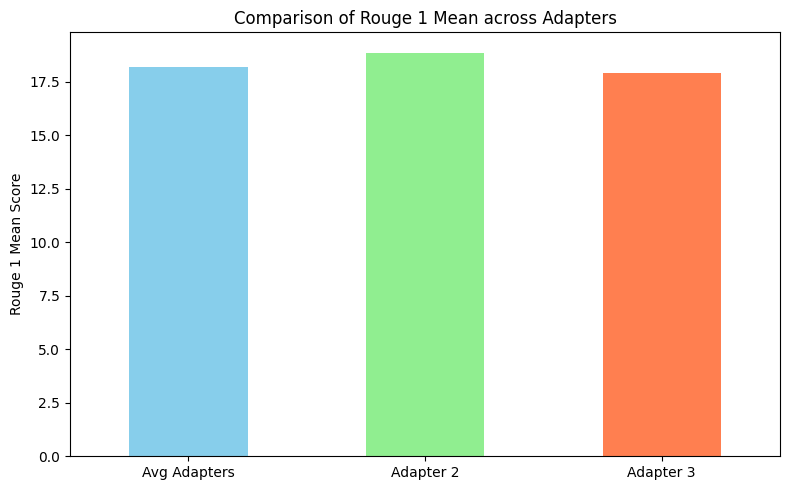

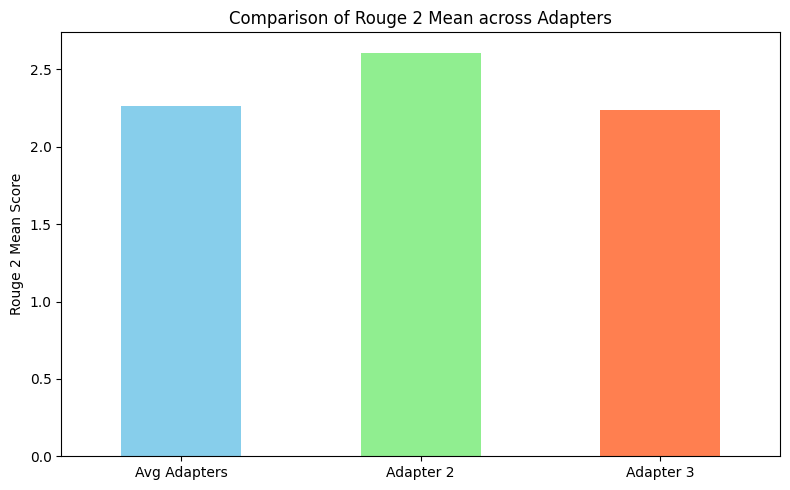

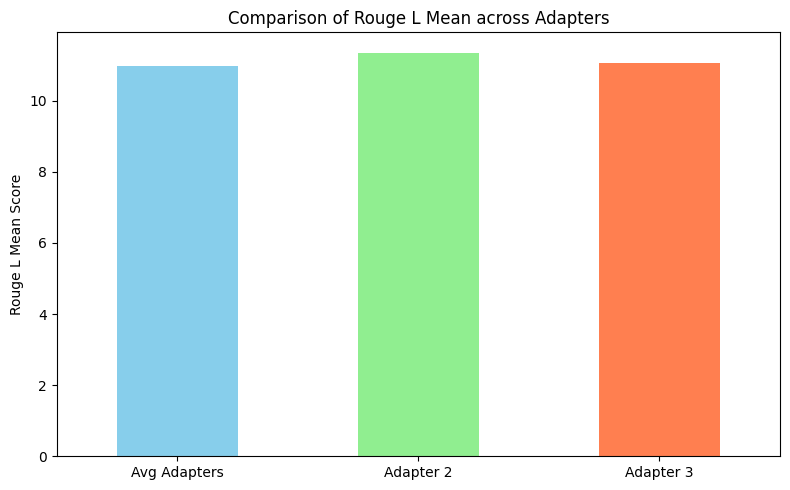

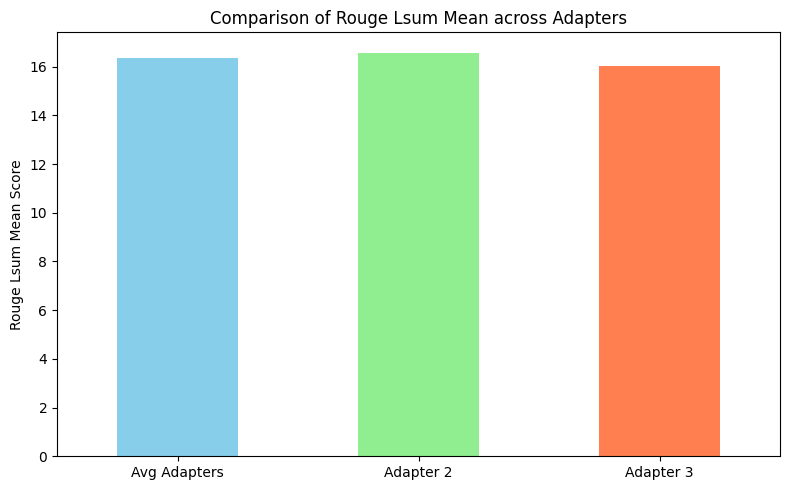

## Inference in batches

In [62]:
# 'dataset_chatml' is a dictionary-like object that contains the dataset.

# 'dataset_chatml['test']' retrieves the test set from the 'dataset_chatml' dataset.

# 'dataset_chatml['test'][0]' retrieves the first sample from the test set.

# 'dataset_chatml['test'][0]['output']' retrieves the 'output' field from the first sample in the test set. This 'output' field typically contains the expected response or output for the given sample.
dataset_chatml['test'][0]['output']

KeyError: 'output'

In [ ]:
# 'num_samples' is a variable that specifies the number of samples to be used for the evaluation.

# In this case, 'num_samples=500' means that 500 samples will be used for the evaluation.
num_samples=500

In [ ]:
%%time
# '%%time' is a magic command in Jupyter Notebook that measures the execution time of the cell it is placed in.

# 'prompts' is a list of prompts that are generated by applying a chat template to the first message of each sample in the test set of the 'dataset_chatml' dataset.

# 'pipe' is an instance of the 'pipeline' class from the 'transformers' library. It is used to generate responses to the prompts.

# 'outputs' is a list of responses that are generated by the 'pipe' pipeline.

# 'preds' is a list of predictions that are extracted from the 'outputs'. Each prediction is the text that follows the "<|assistant|>\n" tag in the generated response.

# 'references' is a list of reference outputs that are extracted from the test set of the 'dataset_chatml' dataset.

# 'rouge_metric.add_batch(predictions=preds, references=references)' adds a batch of predictions and references to the 'rouge_metric' for evaluation.
prompts = [pipe.tokenizer.apply_chat_template([{"role": "user", "content": dataset_chatml['test'][i]['messages'][0]['content']}], tokenize=False, add_generation_prompt=True)
                                              for i in range(num_samples)]
outputs = pipe(prompts, batch_size=4, max_new_tokens=256, do_sample=True, num_beams=1, temperature=0.3, top_k=50, top_p=0.95,
                   max_time= 180)
preds = [outputs[i][0]['generated_text'].split("<|assistant|>\n")[1].strip() for i in range(len(outputs))]
references= [dataset_chatml['test'][i]['output'] for i in range(len(outputs))]
rouge_metric.add_batch(predictions=preds, references=references)

At this point, we can compute the metric for the sample.

In [ ]:
# 'rouge_metric' is an instance of the Rouge metric class from the 'datasets' library.

# 'compute' is a method of the Rouge metric class that calculates the Rouge scores.

# 'use_stemmer=True' is an argument that indicates whether to use stemming when calculating the Rouge scores. Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form.

# So, 'result = rouge_metric.compute(use_stemmer=True)' calculates the Rouge scores with stemming and stores the result in the 'result' variable.
result = rouge_metric.compute(use_stemmer=True)

In [ ]:
# 'np.mean' is a function from the 'numpy' library that calculates the arithmetic mean of an array.

# 'result' is a dictionary that contains the evaluation metrics of the model.

# 'result['rouge1']', 'result['rouge2']', 'result['rougeL']', and 'result['rougeLsum']' are lists of ROUGE scores for each evaluated sample.

# ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate automatic summarization and machine translation. It compares the overlap of n-grams between the system's output and the reference summaries.

# 'print("Rouge 1 Mean: ",np.mean(result['rouge1']))' prints the mean ROUGE-1 score.

# 'print("Rouge 2 Mean: ",np.mean(result['rouge2']))' prints the mean ROUGE-2 score.

# 'print("Rouge L Mean: ",np.mean(result['rougeL']))' prints the mean ROUGE-L score.

# 'print("Rouge Lsum Mean: ",np.mean(result['rougeLsum']))' prints the mean ROUGE-Lsum score.
print("Rouge 1 Mean: ",np.mean(result['rouge1']))
print("Rouge 2 Mean: ",np.mean(result['rouge2']))
print("Rouge L Mean: ",np.mean(result['rougeL']))
print("Rouge Lsum Mean: ",np.mean(result['rougeLsum']))

In [ ]:
# 'result' is a dictionary that contains the evaluation metrics of the model.

# 'result['rouge1']' retrieves the value of the ROUGE-1 score from the 'result' dictionary.

# ROUGE-1 is a metric for evaluating automatic summarization of texts and machine translation. It compares the overlap of unigrams (single words) between the system's output and the reference summaries.
result['rouge1']